# Harmonic Convolution Experiment

This experiment exists to aid the reader's understanding of the situation.


## The following imports are from `mk_main.py`,`hnet_lite.py`

In [1]:
#regular imports.
from typing import Callable
import numpy as np, torch
import matplotlib.pyplot as plt

import sys
sys.path.append("../") #using their convention to import stuff.

#mk_main imports.
from datasets.rotmnist import rotmnist

#hnet_lite imports.
from hnet_lite import Conv2d
from hnet_ops import *
from hnet_ops import h_conv

## Get Data.

In [2]:
val_set = rotmnist.RotMNIST(split = 'valid')

ourdir=PosixPath('/home/ujjawal/Research/code/harmonic-net-pytorch/mldatasets/datasets/rotmnist/rotMNIST')


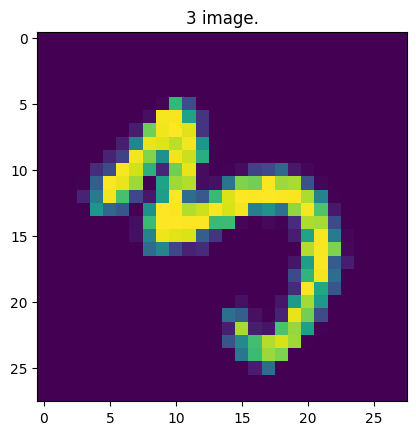

In [3]:
img, lab = val_set[0]
plt.imshow(img)
plt.title(f"{lab} image.")
plt.show()

## Make Conv Layer.

From `hnet_ops.py`

In [4]:
def h_conv(X, W, strides=(1,1,1,1), padding=0, max_order=1):
    """
    This functions performs harmonic convolution operation between the input X
    and weights W. Harmonic convolutions between different orders, also referred
    as cross-stream convolutions, can be converted into a single convolution. 
    See Worrall et al, CVPR 2017 for details.
    
    Args:
        X (pytorch tensor): Input image tensor of shape (bs,h,w,order,complex,channels)
        W (dict of pytorch tensors): Contains tensors for m orders for filters as well
        as the respective phases. 
        strides (tuple of ints): tuple denoting strides for h and w directions. Similar
        to the original tf code as well as the pytorch tuple standard format for stride,
        we provide a 4-size tuple here. The dimensions N and c as per convention are 
        also set to 1.(default (1,1,1,1))
        padding: as per the Pytorch conv2d convention (default: 0)
        max_order: max. order of roation to be modeled(default: 1)

    Returns:
        Y: 
    """	

    Xsh = list(X.size())
    X_ = X.view(Xsh[:3]+[-1]) # flatten out the last 3 dimensions

    # To convert the stream convolutions into a stacked single filter, we
    # combine the components of real and imaginary parts 
    W_ = []
    for out_order in range(max_order+1):
        # For each output order build input
        Wr = []
        Wi = []
        for inp_order in range(Xsh[3]):
            # Difference in orders is the convolution order
            weight_order = out_order - inp_order
            weights = W[np.abs(weight_order)]
            sign = np.sign(weight_order)

            if Xsh[4] == 2:
                Wr += [weights[0],-sign*weights[1]]
                Wi += [sign*weights[1],weights[0]]
            else:
                Wr += [weights[0]]
                Wi += [weights[1]]

        W_ += [torch.cat(Wr, 2), torch.cat(Wi, 2)]
    W_ = torch.cat(W_, 3)

    # Convolving the constructed weights and feature map
    W_ = W_.permute(3, 2, 0, 1)
    W_ = W_.type(torch.cuda.FloatTensor) if torch.cuda.is_available() \
                                            else W_.type(torch.FloatTensor)
    
    X_ = X_.permute(0, 3, 1, 2)
    Y = torch.nn.functional.conv2d(X_, W_, stride=strides, padding=padding)
    Y = Y.permute(0, 2, 3, 1)
    # Reshae results into appropriate format
    Ysh = list(Y.size())
    new_shape = Ysh[:3] + [max_order+1,2] + [Ysh[3]//(2*(max_order+1))]
    Y = Y.view(*new_shape)
    return Y

## Some Useful Functions.

1. Range Int Scaler $F(x): [-\infty, \infty] \rightarrow [r_{min}, r_{max}]$

In [5]:
def min_max_scalar(x: np.ndarray):
    min_x = np.min(x)
    return ((x - min_x) /(np.max(x) - min_x)) 

def sigmoid(x: np.ndarray):
    return 1 / (1 + np.exp(-1 * x))

def range_int_scaler(
    x: np.ndarray,
    rmin: int,
    rmax: int,
    zero_one_map: Callable = min_max_scalar #can be sigmoid(x).
):
    """
    when range of min/max x is unknown,
    use abs(softmax(x)) to map to [0,1].
    """
    #1. map x to [0,1].
    x_01 = zero_one_map(x)
    #2. map x_01 to [rmin, rmax].
    x_mm = rmin + (x_01 * (rmax - rmin))
    return x_mm.round().astype(np.int32)

In [6]:
%%timeit
sample = np.random.rand(99999) #when min, max of param known.
range_int_scaler(sample, 9, 10, min_max_scalar)

634 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
%%timeit
sample = np.random.rand(99999) #when min, max of param not known.
range_int_scaler(sample, 9, 10, sigmoid)

1.05 ms ± 94.3 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
